In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [1]:
import os
import sys
import glob
import datetime
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from astropy import units as u
from astropy.time import Time

from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, leastsq

### Отрисовка шаблона среднего профиля B0531+21

In [2]:
def get_value_by_bins_mjd(table, bin_size, column_name, start_mjd):# разбиение по бинам
    dect_res = {}
    bin_size = bin_size

    for idx, row in table.iterrows():
        bin_num = (float(row['MJD']) - start_mjd)//bin_size
        try:
            dect_res[bin_num].append(row[column_name])
        except KeyError:
            dect_res[bin_num] = []
            dect_res[bin_num].append(row[column_name])

    result = pd.DataFrame(columns=[
        '№ bin',
        'MJD_mean',
        'value',
    ])

    idx = 0
    for key in dect_res.keys():
        result.loc[idx] = [
            key,    
            (key + 0.5)*bin_size + start_mjd,
            np.sum(dect_res[key]),
        ]
        idx +=1

    result = result.sort_values(by=['№ bin'])
    
    return result

def get_mean_by_bins_mjd(table, bin_size, column_name, start_mjd):# разбиение по бинам
    dect_res = {}
    bin_size = bin_size

    for idx, row in table.iterrows():
        bin_num = (float(row['MJD']) - start_mjd)//bin_size
        try:
            dect_res[bin_num].append(row[column_name])
        except KeyError:
            dect_res[bin_num] = []
            dect_res[bin_num].append(row[column_name])

    result = pd.DataFrame(columns=[
        '№ bin',
        'MJD_mean',
        'value',
    ])

    idx = 0
    for key in dect_res.keys():
        result.loc[idx] = [
            key,    
            (key + 0.5)*bin_size + start_mjd,
            np.mean(dect_res[key]),
        ]
        idx +=1

    result = result.sort_values(by=['№ bin'])
    
    return result

#  Инициализация функций 
def screan(t, t_s):
    if t < 0:
        return 0
    else:
        return np.exp(-t/t_s)


def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def my_pulse(x,a,x0,sigma, t_s):
    gs = gauss(x, a, x0, sigma)
    scr = [screan(i, t_s) for i in x] 
    return np.convolve(scr, gs, 'full')[:LEN]

In [6]:
pattern = np.genfromtxt('patterns/total_profile.txt').T

<Figure size 432x288 with 0 Axes>

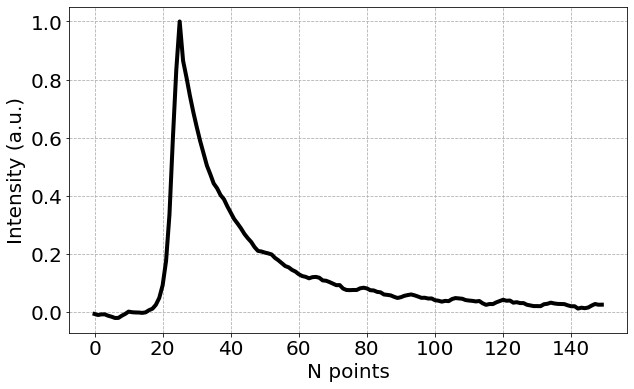

In [11]:
plt.clf()
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 20})
plt.plot(pattern, 'black', lw=4)
plt.ylabel('Intensity (a.u.)')
plt.xlabel('N points')
plt.grid(True, ls = '--')
plt.savefig('some_images/total_pattern.eps', format='eps')

### Отрсовка ГИ по дате и номеру 

In [61]:
date = '2015.05.19'
nomer = '0'
filename = f'results_set/file_untypized/{date}_plot_0531+21_{nomer}.csv'
pulse = np.genfromtxt(filename, skip_header=6).T

B0531+21 2015.05.19


<Figure size 432x288 with 0 Axes>

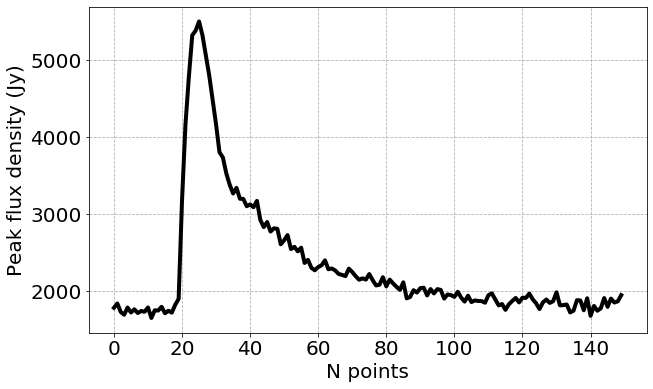

In [62]:
plt.clf()
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 20})
#plt.title(f'B0531+21 {date}')
plt.plot(pulse + 1720, 'black', lw=4)
plt.ylabel('Peak flux density (Jy)')
plt.xlabel('N points')
plt.grid(True, ls = '--')
plt.savefig('some_images/pulse_example.eps', format='eps')
print(f'B0531+21 {date}')

In [58]:
np.max(pulse)

930.465

## Отрисовка вписанной функции

<Figure size 432x288 with 0 Axes>

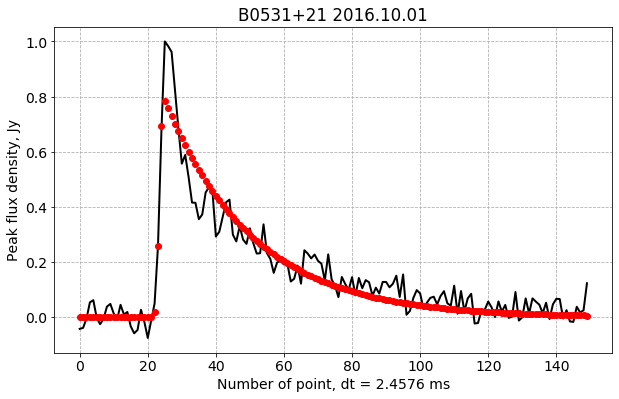

In [21]:
T_SCATTERING = 15.85
LEN = len(pulse)
    
x = np.linspace(0, LEN, LEN)
normal_pulse = pulse/max(pulse)

amp = 1
mean = 25
sigma = 3
t_s = 10

p0 = [amp,mean,sigma, t_s]

popt,pcov = curve_fit(my_pulse,x,normal_pulse,p0=p0, maxfev=100000)
new_pulse = my_pulse(x,*popt)

plt.clf()
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
plt.title(f'B0531+21 {date}')
plt.plot(normal_pulse, 'black', lw=2)
plt.plot(new_pulse, 'ro')
plt.ylabel('Peak flux density, Jy')
plt.xlabel('Number of point, dt = 2.4576 ms')
plt.grid(True, ls = '--')
#plt.savefig(f'some_images/fit_pulse_example_{date}_{nomer}.eps', format='eps')

### Отрисовка количества сеансов

In [22]:
crab_sessoins = pd.read_table('crab_session_kaz_2020-04-26.csv', sep='\t')

In [23]:
# Отсечка c 13.02.2010 55240.686525
# Отсечка по 25.04.2019 58598.493969
crab_sessoins = crab_sessoins[1:2005].reset_index(drop=True)

In [24]:
resul_tab_sessoins = get_value_by_bins_mjd(
    crab_sessoins, 30, 'Session', crab_sessoins['MJD'][0])

In [25]:
len(crab_sessoins)

2004

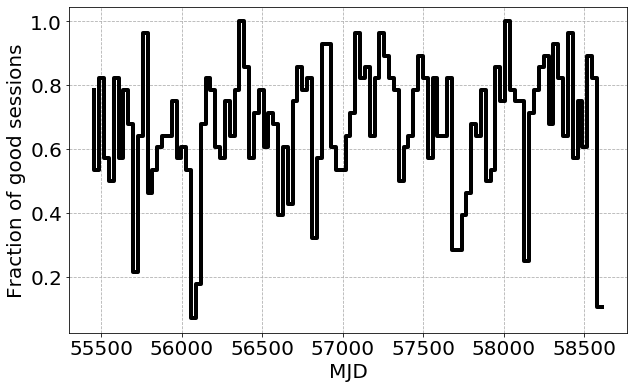

In [30]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 20})
plt.step(resul_tab_sessoins.MJD_mean,
         resul_tab_sessoins.value/resul_tab_sessoins.value.max(), color='black', lw=4)
plt.ylabel('Fraction of good sessions')
plt.xlabel('MJD')
plt.grid(True, ls='--')
plt.savefig('some_images/sessions.eps', format='eps')

### Отрисовка выплащивания сеанса

In [33]:
def flatter(data, polynomialOrder=15):

    ## Применяем медианную фильтрацию с максимальным шагом:
    res_filter = signal.medfilt(data, kernel_size=29)
    # Фитируем получившийся массив:
    xData = range(len(res_filter))
    yData = res_filter
    # curve fit the data
    fittedParameters = np.polyfit(xData, yData, polynomialOrder)
    xModel = np.linspace(min(xData), max(xData), len(xData))
    yModel = np.polyval(fittedParameters, xModel)

    return yModel


def sinxx(x):
    return (np.sin(x)/x)**2


def beam_obs(x, amp,  shift, y0):
    return amp*(np.sin(x + shift)/(x + shift))**2 + y0


if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "D:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "D:\\YandexDisk\\1.Работа\\Результаты обработки\\"

elif 'Linux' in platform.platform():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"

else:
    print('unknown system', platform.platform(), platform.release())

sys.path.append(PACK_DIR)
from PRAO import *

In [34]:
files_0531 = glob.glob(f'{ALL_DATA}0531+21{os.sep}*{os.sep}*{os.sep}*_profiles.txt')
print(f'Main object: 0531+21; Numbers of files: {len(files_0531)}')

# установка диапазона дат
date_start = datetime.datetime(2009, 11, 20, 0, 0)
data_stop = datetime.datetime(2019, 11, 18, 0, 0)

main_set = [x for x in files_0531
             if date_start <= datetime.datetime.strptime(os.path.basename(x)[:6], '%d%m%y') <= data_stop]
print(f'Main set: 0531+21; Numbers of files: {len(main_set)}')

Main object: 0531+21; Numbers of files: 3040
Main set: 0531+21; Numbers of files: 3040


In [35]:
date = '190515_'
file = [i for i in main_set if date in i][0]

In [36]:
head, main_pulse, data_pulses, back = read_profiles_MD(file)
day, month, year = head['date'].split('.')
            
non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)

fullpoints = int(head['numpuls'])*int(head['numpointwin'])
x = np.linspace(-1.37, 1.37, fullpoints)

obspoints = fullpoints - int(head['numpointwin'])

y = sinxx(x[:obspoints])
x = x[:obspoints]

poli = flatter(obser, 4)
max_calib = max(poli)
amp = max_calib
shift = 0
y0 = 50
popt,pcov = curve_fit(beam_obs,x,obser,p0=[amp,shift, y0])

beam_coeff = beam_obs(x,*popt)
coeff = 1720/(amp - popt[2])
obser_calib = coeff*obser
y0_back = popt[2]*coeff

cor_d = []
for data_point, coeff in zip(obser_calib, beam_coeff/np.max(beam_coeff)):
    cor_d.append(data_point/coeff)
cor_d = np.asarray(cor_d)
cor_d -= y0_back

poli_13 = flatter(cor_d, 13)
flat_obser = (cor_d - poli_13) + np.median(cor_d)  # Калибровка
med_flat_obser = np.median(flat_obser)

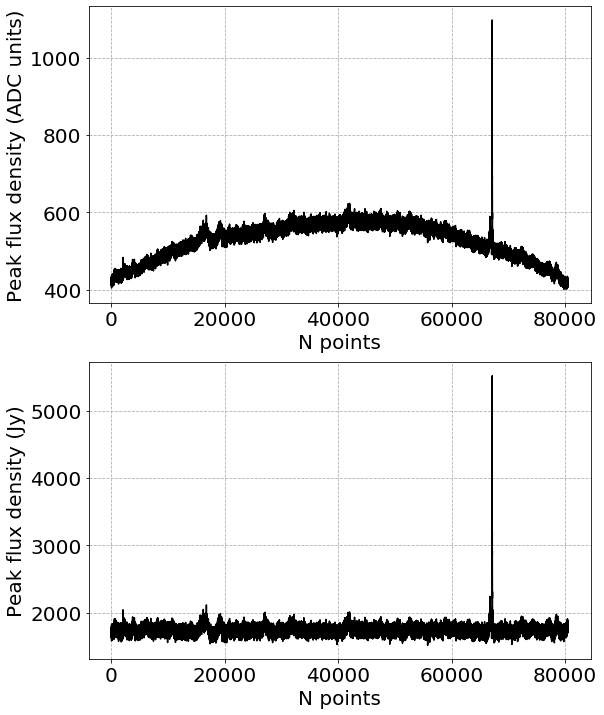

In [63]:
plt.close()
plt.figure(figsize=(9, 12))
plt.subplot(211)
#plt.title(f'B0531+21 {year}.{month}.{day}')
plt.plot(obser, color='black')
plt.grid(True, ls='--')
plt.ylabel('Peak flux density (ADC units)')
plt.xlabel(f"N points")
plt.subplot(212)
plt.plot(flat_obser, color='black')
plt.ylabel('Peak flux density (Jy)')
plt.xlabel(f"N points")
plt.grid(True, ls='--')
plt.savefig('some_images/one_session.eps', format='eps')

### Отрисовка темпа генерации

In [64]:
gp_table = pd.read_csv('crab_gp_kaz_pulses_2020-07-31.csv', sep='\t')

In [65]:
gp_table['gp'] = 1
start_mjd = 55440

In [66]:
gp_table.head()

,Date,Time start,MJD,"Median, Jy","amp of gp, Jy","W50, point","W10, point","W50_19D_poly, point","W10_19D_poly, point","W50_fit_func, point","W10_fit_func, point","E_19D_poly, Jy*ms","E_fit_func, Jy*ms","Tay, ms","STD, Jy","STD_without_pulse, Jy",gp
0,13.02.2010,20:26:28.9413394,55240.686525,1744.818640,269.376400,8.41850,63.16855,33.3888,64.1284,44.4222,138.0914,32034.832898,28898.736355,2.4576,42.117403,41.890580,1
1,04.09.2010,07:08:21.3085403,55443.131314,1717.647895,176.650285,17.00090,30.15760,34.3582,80.6304,25.2044,76.9230,21617.568980,12872.655870,2.4576,36.229961,35.997642,1
2,04.09.2010,07:08:21.3085403,55443.131314,1717.647895,158.318875,8.15030,39.28385,32.4268,68.7682,41.2328,128.1532,18285.165509,15387.322591,2.4576,36.229961,35.997642,1
3,05.09.2010,07:04:25.4187240,55444.129131,1718.033010,411.753190,11.70395,49.80325,22.0594,132.5044,23.8058,72.8308,32351.377388,28987.203741,2.4576,41.160847,40.701186,1
4,05.09.2010,07:04:25.4187240,55444.129131,1718.033010,228.012950,2.10090,32.54905,22.5034,129.2706,55.7368,137.2626,18275.520758,22147.841144,2.4576,41.160847,40.701186,1


In [67]:
# Отсечка c 13.02.2010 55240.686525
# Отсечка по 25.04.2019 58598.493969
gp_table = gp_table[1:8754].reset_index(drop=True)

In [68]:
len(gp_table)

8753

## Загрузка и отрисовка коэффициента амплитуды фитирования диаграммы.

In [69]:
coeff_table = pd.read_table('beam_coeff_obs_kaz.csv', sep='\t')
coeff_table['Time_series'] = pd.to_datetime(coeff_table['Date'], format='%d.%m.%Y', errors='ignore')
coeff_table = coeff_table.set_index('Time_series')

In [70]:
coeff_table

,Date,A,shift,y0,Jy/ADC
Time_series,,,,,
2010-02-13,13.02.2010,299.752556,0.119072,210.750382,5.822553
2010-09-04,04.09.2010,347.494600,0.097007,100.154814,4.944975
2010-09-05,05.09.2010,330.253045,-0.111377,123.377004,5.214764
2010-09-06,06.09.2010,350.387846,0.077762,122.166582,4.912586
2010-09-07,07.09.2010,257.280328,0.184195,118.349339,6.686779
...,...,...,...,...,...
2019-09-10,10.09.2019,20.294635,0.130456,12.689191,85.799973
2019-09-16,16.09.2019,20.966289,-0.036010,21.739735,83.637834
2019-09-17,17.09.2019,8.598572,0.030083,15.326336,204.362220


In [71]:
coeff_table['MJD'] = None
for index, row in coeff_table.iterrows():
    year, month, day  = str(index).split()[0].split('-')
    time_utc = (Time('{}-{}-{}T'.format(year, month, day) + '00:00:00.0000000', precision=7) - 4*u.hour)
    coeff_table['MJD'].loc[index] = str(time_utc.mjd)

/home/andr/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [72]:
resul_coeff_table = get_mean_by_bins_mjd(coeff_table, 30, 'A', start_mjd)

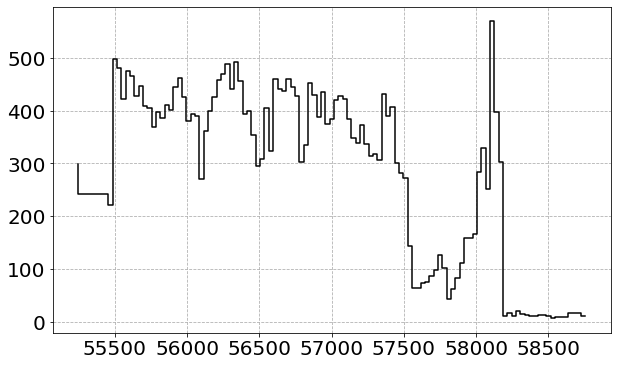

In [73]:
plt.figure(figsize=(10,6))
plt.step(resul_coeff_table.MJD_mean, resul_coeff_table.value, color='black')
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
#plt.show()

In [144]:
resul_gp = get_value_by_bins_mjd(gp_table, 30, 'gp', start_mjd)
cut_session = get_value_by_bins_mjd(crab_sessoins, 30, 'Session', start_mjd)

In [145]:
rate = pd.merge(
        resul_gp, cut_session, on='MJD_mean', how='outer', suffixes=('_gp', '_session'))
rate.where(~np.isnan(rate), other = None, inplace = True)
rate['time_obs'] = rate.value_session*3.3841152
rate['rate'] = rate.value_gp/rate.time_obs

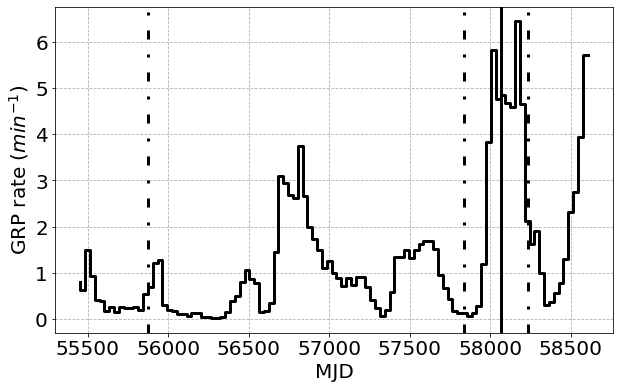

In [148]:
plt.figure(figsize=(10,6))
plt.step(rate.MJD_mean, rate.rate, color='black', lw=3)
plt.ylabel(r'GRP rate ($min^{-1}$)')
plt.xlabel('MJD')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate.eps', format='eps')

### Отрисовка усредненного по месяцу STD

In [81]:
resul_gp_std = get_mean_by_bins_mjd(gp_table, 30, 'STD, Jy', start_mjd)

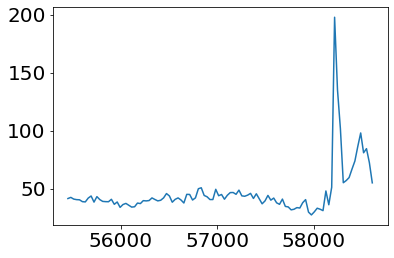

In [82]:
plt.clf()
plt.plot(resul_gp_std.MJD_mean, resul_gp_std.value)
#plt.show()

In [83]:
gp_table

,Date,Time start,MJD,"Median, Jy","amp of gp, Jy","W50, point","W10, point","W50_19D_poly, point","W10_19D_poly, point","W50_fit_func, point","W10_fit_func, point","E_19D_poly, Jy*ms","E_fit_func, Jy*ms","Tay, ms","STD, Jy","STD_without_pulse, Jy",gp
0,04.09.2010,07:08:21.3085403,55443.131314,1717.647895,176.650285,17.00090,30.15760,34.3582,80.6304,25.2044,76.9230,21617.568980,12872.655870,2.4576,36.229961,35.997642,1
1,04.09.2010,07:08:21.3085403,55443.131314,1717.647895,158.318875,8.15030,39.28385,32.4268,68.7682,41.2328,128.1532,18285.165509,15387.322591,2.4576,36.229961,35.997642,1
2,05.09.2010,07:04:25.4187240,55444.129131,1718.033010,411.753190,11.70395,49.80325,22.0594,132.5044,23.8058,72.8308,32351.377388,28987.203741,2.4576,41.160847,40.701186,1
3,05.09.2010,07:04:25.4187240,55444.129131,1718.033010,228.012950,2.10090,32.54905,22.5034,129.2706,55.7368,137.2626,18275.520758,22147.841144,2.4576,41.160847,40.701186,1
4,05.09.2010,07:04:25.4187240,55444.129131,1718.033010,183.012450,2.57025,25.17355,25.0120,45.7838,21.5044,56.8838,16303.887224,7995.216616,2.4576,41.160847,40.701186,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8748,25.04.2019,15:48:35.0213470,58598.493969,1747.141440,308.429170,3.24820,12.58305,18.5592,40.1598,21.3934,70.7810,20388.102329,16003.406609,2.4576,60.846623,59.299000,1
8749,25.04.2019,15:48:35.0213470,58598.493969,1747.141440,307.361140,4.58175,15.98770,15.6140,25.1526,9.9974,32.9522,17093.273475,10523.679071,2.4576,60.846623,59.299000,1
8750,25.04.2019,15:48:35.0213470,58598.493969,1747.141440,302.191510,8.62710,10.28100,14.1118,39.9156,9.5386,28.0534,15188.915960,9395.475382,2.4576,60.846623,59.299000,1
8751,25.04.2019,15:48:35.0213470,58598.493969,1747.141440,279.728370,5.13305,23.25890,14.6224,23.9760,13.9712,43.0976,14568.581984,10845.916666,2.4576,60.846623,59.299000,1


In [84]:
# Сделать новые данные для std
old_date = '03.09.2010'
idx_pulse = 0
gp_table['New STD'] = None
for idx, row in gp_table.iterrows():
    day, month, year = row['Date'].split('.')
    date = f'{year}.{month}.{day}'
    
    if date == old_date:
        filename = f'results_set/dina_results/files/{date}_plot_0531+21_{idx_pulse}.csv'
        pulse = np.genfromtxt(filename, skip_header=6).T
        gp_table['New STD'].iloc[idx] = np.std(pulse[:16])
        
        old_date = date
        idx_pulse += 1
    else:
        idx_pulse = 0
        old_date = date
        filename = f'results_set/dina_results/files/{date}_plot_0531+21_{idx_pulse}.csv'
        pulse = np.genfromtxt(filename, skip_header=6).T
        gp_table['New STD'].iloc[idx] = np.std(pulse[:16])

In [85]:
resul_gp_std_new = get_mean_by_bins_mjd(gp_table, 30, 'New STD', start_mjd)

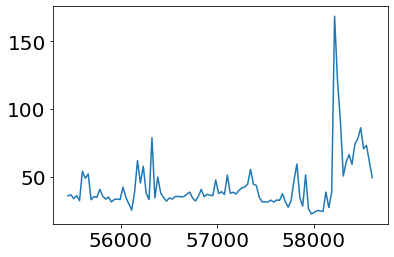

In [86]:
plt.clf()
plt.plot(resul_gp_std_new.MJD_mean, resul_gp_std_new.value)
# plt.show()

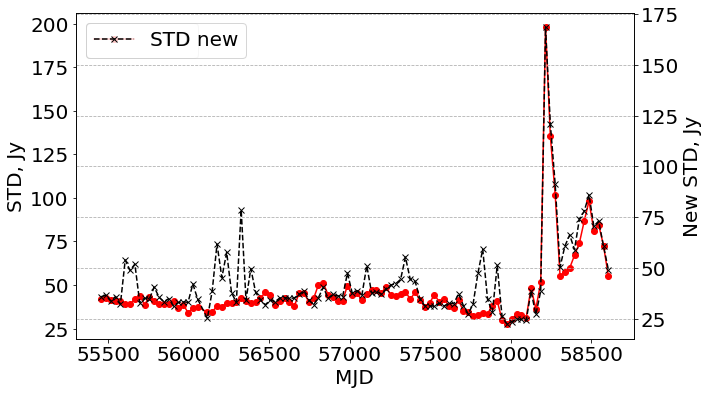

In [87]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(resul_gp_std.MJD_mean, resul_gp_std.value, 'o-', color='red', label='STD')
ax2.plot(
    resul_gp_std_new.MJD_mean, resul_gp_std_new.value, 'xb--', color='black', label='STD new')

ax1.set_xlabel('MJD')
ax1.set_ylabel('STD, Jy')
ax2.set_ylabel(r'New STD, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend()
ax2.legend()
plt.grid(True, ls='--')
# plt.savefig('some_images/stds.eps', format='eps')

In [88]:
resul_gp_std_without_pulse = get_mean_by_bins_mjd(gp_table, 30, 'STD_without_pulse, Jy', start_mjd)

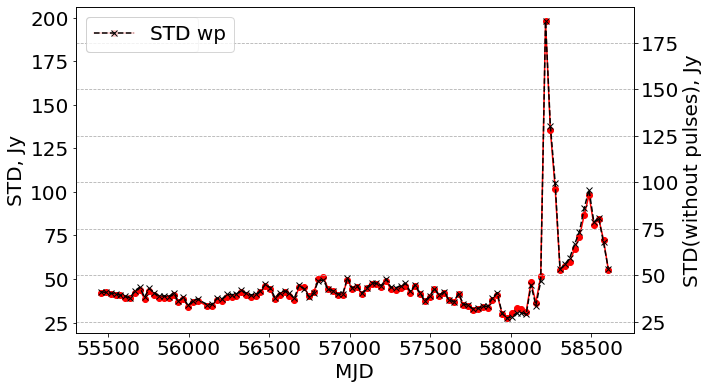

In [89]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(resul_gp_std.MJD_mean, resul_gp_std.value, 'o-', color='red', label='STD')
ax2.plot(
    resul_gp_std_without_pulse.MJD_mean, resul_gp_std_without_pulse.value,
    'xb--', color='black', label='STD wp')

ax1.set_xlabel('MJD')
ax1.set_ylabel('STD, Jy')
ax2.set_ylabel(r'STD(without pulses), Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend()
ax2.legend()
plt.grid(True, ls='--')
# plt.savefig('some_images/stds_without pulses.eps', format='eps')

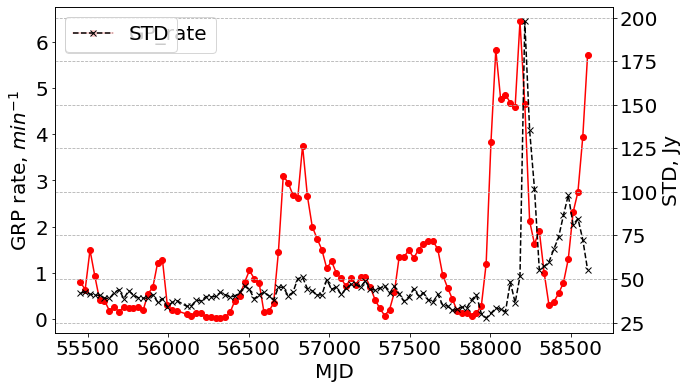

In [91]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GP_rate')
ax2.plot(
    resul_gp_std.MJD_mean, resul_gp_std.value, 'xb--', color='black', label='STD')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'STD, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend()
ax2.legend()
plt.grid(True, ls='--')
# plt.savefig('some_images/gp+stds.eps', format='eps')

### Отрисовка логарифма пиковой плотности потока по регионам

### Отрисовка энергии по регионам c отсечкой по энергии

In [139]:
gp_table_cut_E = gp_table[gp_table['E_fit_func, Jy*ms'] > 50_000]
resul_gp_cut_E = get_value_by_bins_mjd(gp_table_cut_E, 30, 'gp', start_mjd)
cut_session = get_value_by_bins_mjd(crab_sessoins, 30, 'Session', start_mjd)

rate_cut_E = pd.merge(
        resul_gp_cut_E, cut_session, on='MJD_mean', how='outer', suffixes=('_gp', '_session'))
rate_cut_E.where(~np.isnan(rate_cut_E), other = None, inplace = True)
rate_cut_E['time_obs'] = rate_cut_E.value_session*3.3841152
rate_cut_E['rate'] = rate_cut_E.value_gp/rate_cut_E.time_obs

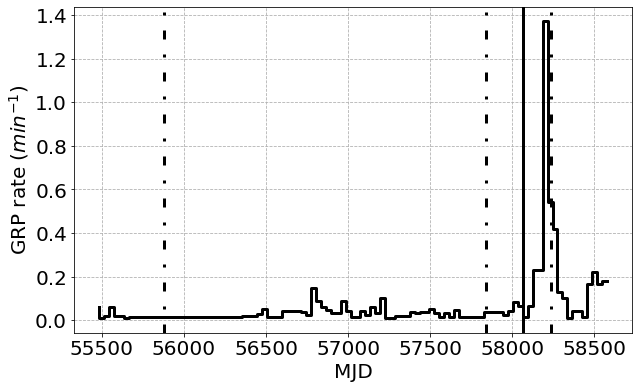

In [141]:
plt.figure(figsize=(10,6))
plt.step(rate_cut_E.MJD_mean, rate_cut_E.rate, color='black', lw=3)
plt.ylabel(r'GRP rate ($min^{-1})$')
plt.xlabel('MJD')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate_cut_E.eps', format='eps')

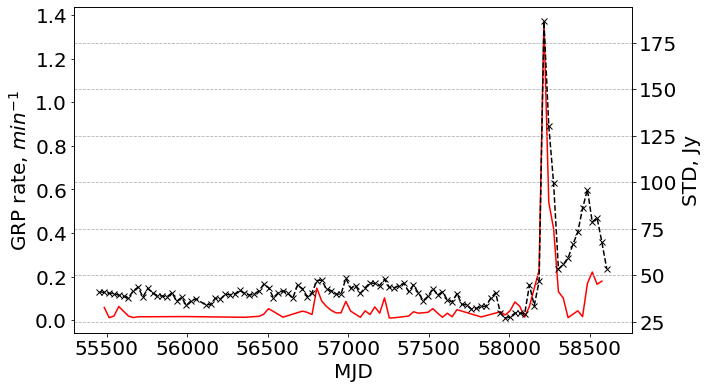

In [99]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate_cut_E.MJD_mean, rate_cut_E.rate, color='red')
ax2.plot(resul_gp_std_without_pulse.MJD_mean, resul_gp_std_without_pulse.value,
    'xb--', color='black', label='STD wp')
ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'STD, Jy')
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
# plt.savefig('some_images/gp_rate_cut_E+stds.eps', format='eps')

## Отрисовка коэффициента амплитуды фитирования совместно с темпом генерации

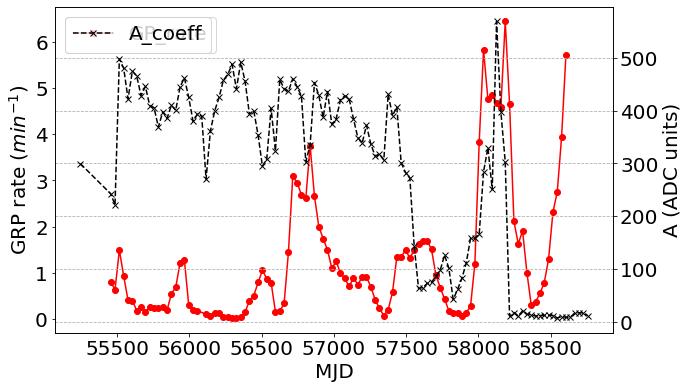

In [100]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GP_rate')
ax2.plot(
    resul_coeff_table.MJD_mean, resul_coeff_table.value, 'xb--', color='black', label='A_coeff')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate ($min^{-1}$)')
ax2.set_ylabel(r'A (ADC units)')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend()
ax2.legend()
plt.grid(True, ls='--')
# plt.savefig('some_images/gp+a_coeff.eps', format='eps')

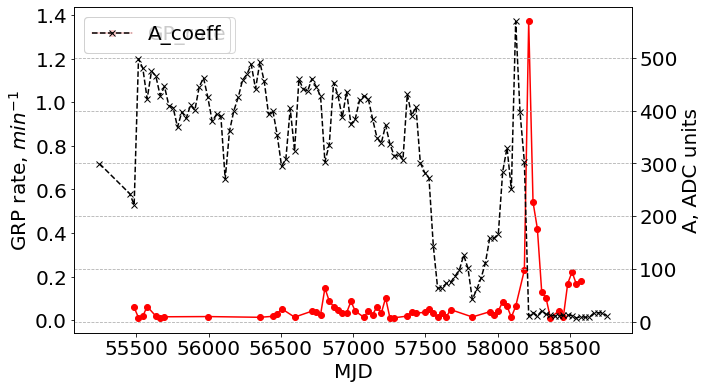

In [101]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate_cut_E.MJD_mean, rate_cut_E.rate, 'o-', color='red', label='GP_rate')
ax2.plot(resul_coeff_table.MJD_mean, resul_coeff_table.value,
    'xb--', color='black', label='A_coeff')
ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'A, ADC units')
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
ax1.legend()
ax2.legend()
# plt.savefig('some_images/gp_rate_cut_E+a_coeff.eps', format='eps')

In [102]:
gp_table_cut_E = gp_table[gp_table['E_fit_func, Jy*ms'] > 50_000]
resul_gp_cut_E = get_value_by_bins_mjd(gp_table_cut_E, 1, 'gp', start_mjd)
cut_session = get_value_by_bins_mjd(crab_sessoins, 1, 'Session', start_mjd)

rate_cut_E = pd.merge(
        resul_gp_cut_E, cut_session, on='MJD_mean', how='outer', suffixes=('_gp', '_session'))
rate_cut_E.where(~np.isnan(rate_cut_E), other = None, inplace = True)
rate_cut_E['time_obs'] = rate_cut_E.value_session*3.3841152
rate_cut_E['rate'] = rate_cut_E.value_gp/rate_cut_E.time_obs

In [103]:
rate_cut_E.MJD_mean.iloc[128]

58199.5

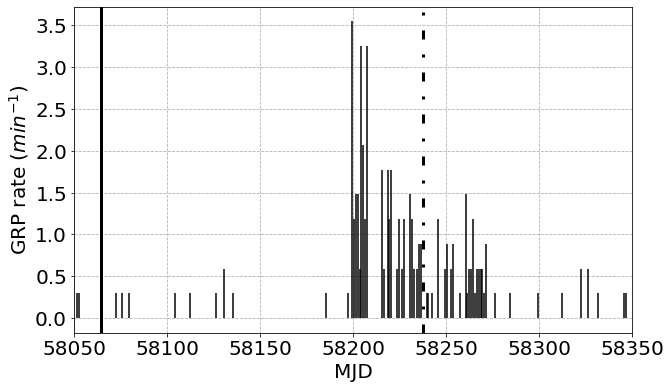

In [137]:
plt.figure(figsize=(10,6))
plt.vlines(rate_cut_E.MJD_mean, 0, rate_cut_E.rate, color='black')
plt.ylabel(r'GRP rate ($min^{-1}$)')
plt.xlabel('MJD')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.grid(True, ls='--')
plt.xlim(58050,58350)
plt.savefig('some_images/gp_rate_cut_E_1day_resolution_shifted.eps', format='eps')

### Отрисовка логарифма потока и энергии за все дни

<Figure size 432x288 with 0 Axes>

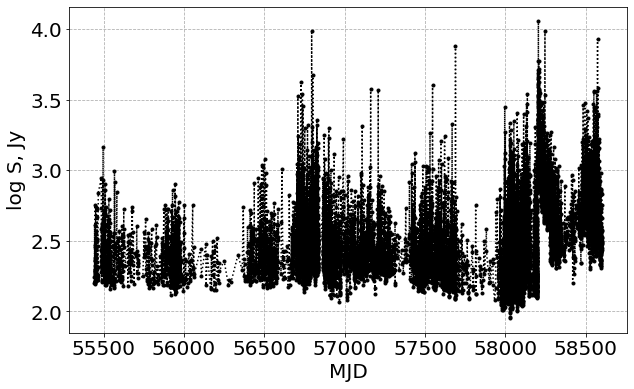

In [105]:
plt.clf()
plt.figure(figsize=(10,6))
plt.ylabel('log S, Jy')
plt.xlabel('MJD')
plt.plot(gp_table['MJD'], np.log10(gp_table['amp of gp, Jy']), '.:', color='black')
plt.grid(True, ls='--')
plt.savefig('some_images/flux.eps', format='eps')

In [106]:
plot_e = gp_table[gp_table['E_fit_func, Jy*ms'] > 100] 
# убираем сильные скачки в низ от неправильного определения энергии

<Figure size 432x288 with 0 Axes>

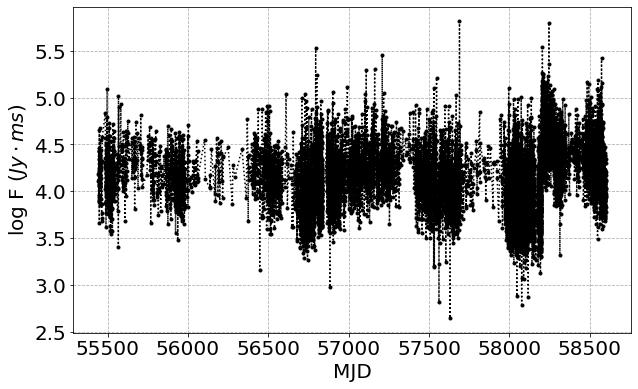

In [134]:
plt.clf()
plt.figure(figsize=(10,6))
plt.ylabel('log F ($Jy \cdot ms$)')
plt.xlabel('MJD')
plt.plot(plot_e['MJD'], np.log10(plot_e['E_fit_func, Jy*ms']), '.:', color='black')
plt.grid(True, ls='--')

plt.savefig('some_images/fluence.eps', format='eps')

<Figure size 432x288 with 0 Axes>

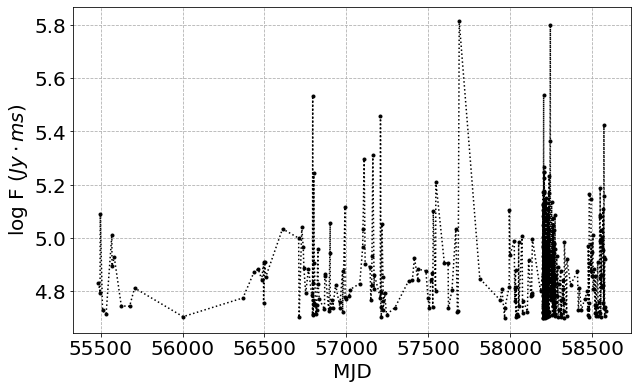

In [143]:
plt.clf()
plt.figure(figsize=(10,6))
plt.ylabel('log F ($Jy \cdot ms$)')
plt.xlabel('MJD')
plt.plot(gp_table_cut_E['MJD'], np.log10(gp_table_cut_E['E_fit_func, Jy*ms']), '.:', color='black')
plt.grid(True, ls='--')

plt.savefig('some_images/fluence_cut_E.eps', format='eps')

### Отрисовка рассеяния

In [109]:
dect_res = {}
bin_size = 30

In [110]:
gp_table.columns

Index(['Date', 'Time start', 'MJD', 'Median, Jy', 'amp of gp, Jy',
       'W50, point', 'W10, point', 'W50_19D_poly, point',
       'W10_19D_poly, point', 'W50_fit_func, point', 'W10_fit_func, point',
       'E_19D_poly, Jy*ms', 'E_fit_func, Jy*ms', 'Tay, ms', 'STD, Jy',
       'STD_without_pulse, Jy', 'gp', 'New STD'],
      dtype='object')

In [111]:
for idx, row in gp_table.iterrows():
    bin_num = (row['MJD'] - start_mjd)//bin_size
    try:
        dect_res[bin_num].append(row['W50_fit_func, point']*row['Tay, ms']*1.44)
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['W50_fit_func, point']*row['Tay, ms']*1.44)

In [112]:
resul_tab_w50 = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'W50_mean',
    'STD',
    'len bin'])

In [113]:
idx = 0
for key in dect_res.keys():
    resul_tab_w50.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + start_mjd,
        np.mean(dect_res[key]),
        np.std(dect_res[key]),
        np.size(dect_res[key])
    ]
    idx +=1

In [114]:
resul_tab_w50 = resul_tab_w50.sort_values(by=['№ bin'])

In [115]:
resul_tab_w50.loc[25]['W50_mean'] = None

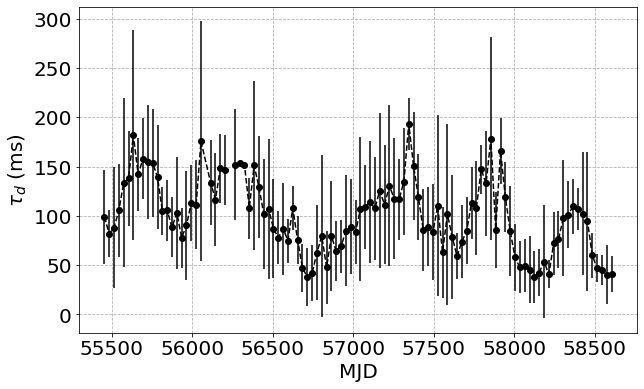

In [149]:
plt.figure(figsize=(10,6))
plt.errorbar(resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'],
             yerr=resul_tab_w50['STD'], color='black', fmt='--o')
plt.ylabel(r'$\tau_d$ (ms)')
plt.xlabel('MJD')
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter.eps', format='eps')

## Отрисовка рассеяние + другие графики

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


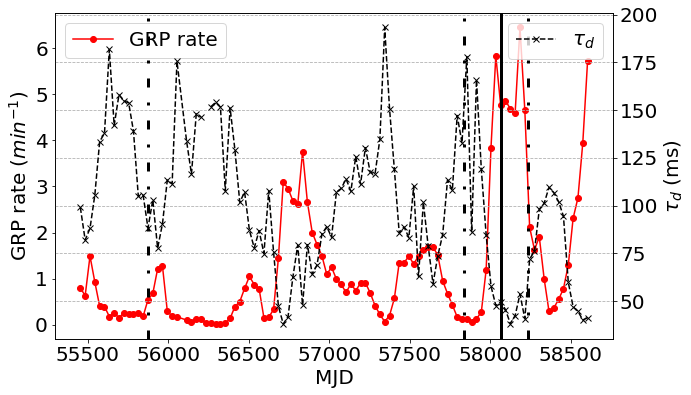

In [142]:
fig, ax1 = plt.subplots(figsize=(10,6))
plt.rcParams.update({'font.size': 20})
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GRP rate')
ax2.plot(
    resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'], 'xb--', color='black', label=r'$\tau_d$')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate ($min^{-1}$)')
ax2.set_ylabel(r'$\tau_d$ (ms)')
plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
plt.axvline(58064.55, color='black', lw=3) # strongest glitch
plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter+gp_rate.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


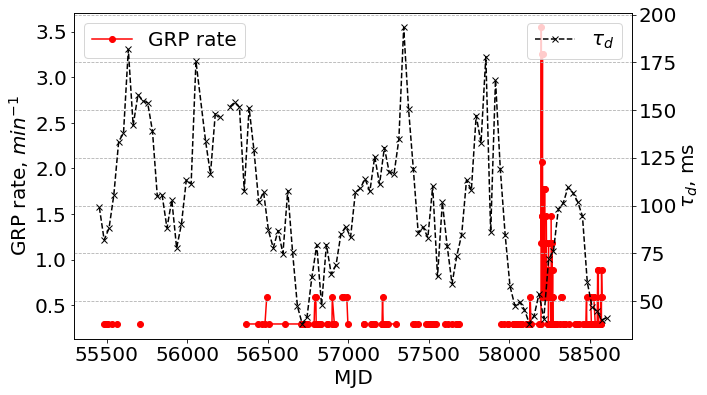

In [118]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate_cut_E.MJD_mean, rate_cut_E.rate, 'o-', color='red', label='GRP rate')
ax2.plot(
    resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'], 'xb--', color='black', label=r'$\tau_d$')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'$\tau_d$, ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
plt.savefig('some_images/t_scatter+gp_rate_cut_E.eps', format='eps')

In [119]:
dect_res = {}
bin_size = 30

for idx, row in gp_table_cut_E.iterrows():
    bin_num = (row['MJD'] - start_mjd)//bin_size
    try:
        dect_res[bin_num].append(row['E_fit_func, Jy*ms'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['E_fit_func, Jy*ms'])
        
resul_tab_cut_E = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'E_mean'
])

idx = 0
for key in dect_res.keys():
    resul_tab_cut_E.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + start_mjd,
        np.mean(dect_res[key])
    ]
    idx +=1

resul_tab_cut_E = resul_tab_cut_E.sort_values(by=['№ bin'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


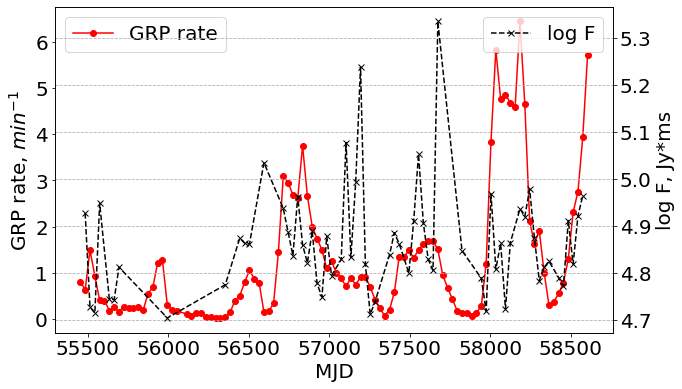

In [120]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab_cut_E.MJD_mean, np.log10(resul_tab_cut_E.E_mean),
         'xb--', color='black', label='log F')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'log F, Jy*ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate+fluence_mean_bin_30.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


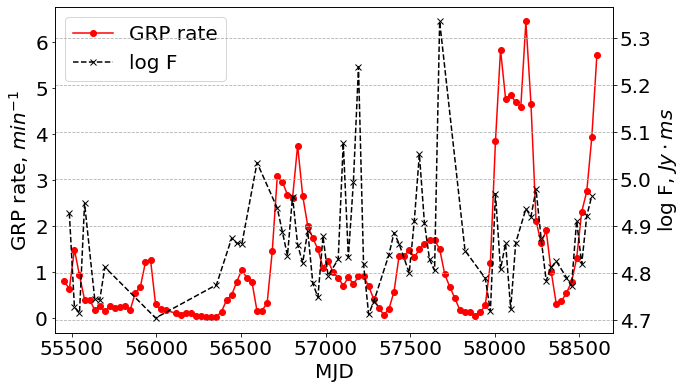

In [121]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GRP rate')
ax1.plot(0, 0, 'xb--', color='black', label='log F')
ax2.plot(resul_tab_cut_E.MJD_mean, np.log10(resul_tab_cut_E.E_mean),
         'xb--', color='black')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel(r'log F, $Jy \cdot ms$')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
plt.grid(True, ls='--')
plt.xlim(55400, 58700)
plt.savefig('some_images/gp_rate+fluence_mean_bin_30.eps', format='eps')

In [122]:
dect_res = {}
bin_size = 30

for idx, row in gp_table_cut_E.iterrows():
    bin_num = (row['MJD'] - start_mjd)//bin_size
    try:
        dect_res[bin_num].append(row['amp of gp, Jy'])
    except KeyError:
        dect_res[bin_num] = []
        dect_res[bin_num].append(row['amp of gp, Jy'])
        
resul_tab_cut_I = pd.DataFrame(columns=[
    '№ bin',
    'MJD_mean',
    'I_mean'
])

idx = 0
for key in dect_res.keys():
    resul_tab_cut_I.loc[idx] = [
        key,    
        (key + 0.5)*bin_size + start_mjd,
        np.mean(dect_res[key])
    ]
    idx +=1

resul_tab_cut_I = resul_tab_cut_I.sort_values(by=['№ bin'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


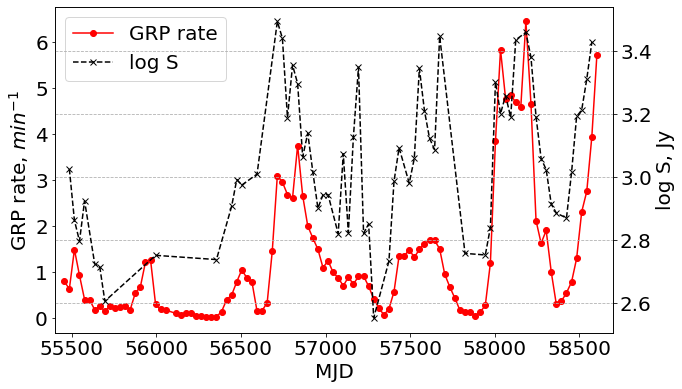

In [123]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate.MJD_mean, rate.rate, 'o-', color='red', label='GRP rate')
ax1.plot(0, 0, 'xb--', color='black', label='log S')
ax2.plot(resul_tab_cut_I.MJD_mean, np.log10(resul_tab_cut_I.I_mean),
         'xb--', color='black')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel('log S, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
plt.grid(True, ls='--')
plt.xlim(55400, 58700)
plt.savefig('some_images/gp_rate+flux_mean_bin_30.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


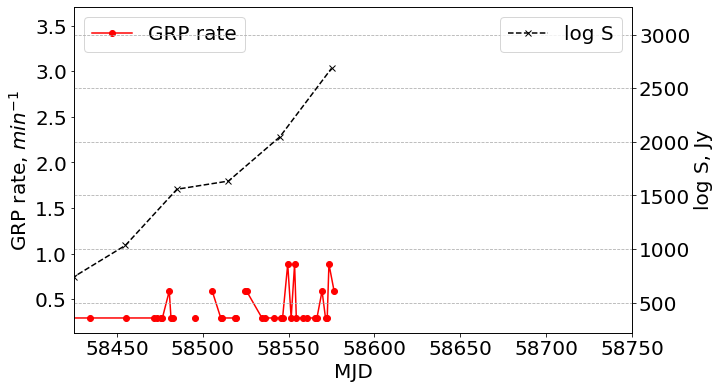

In [127]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(rate_cut_E.MJD_mean, rate_cut_E.rate, 'o-', color='red', label='GRP rate')
ax2.plot(resul_tab_cut_I.MJD_mean, resul_tab_cut_I.I_mean,
         'xb--', color='black', label='log S')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'GRP rate, $min^{-1}$')
ax2.set_ylabel('log S, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
plt.xlim(58425, 58750)
plt.savefig('some_images/gp_rate_cut_E+flux_mean_bin_30.eps', format='eps')

## Отрисовка потока и энергии совместно с рассеянием

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


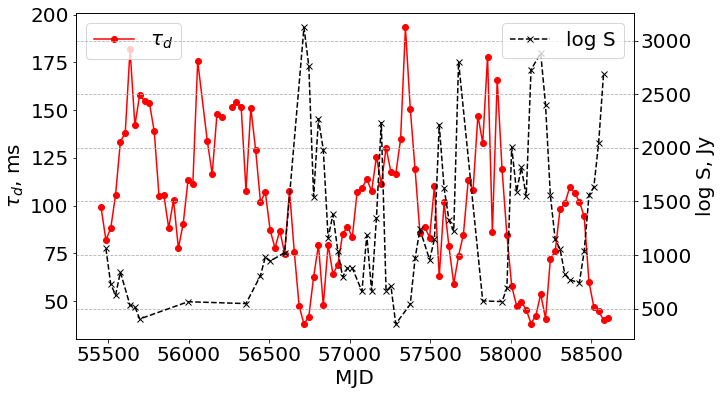

In [125]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(
    resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'], 'o-', color='red', label=r'$\tau_d$')
ax2.plot(
    resul_tab_cut_I.MJD_mean, resul_tab_cut_I.I_mean, 'xb--', color='black', label='log S')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'$\tau_d$, ms')
ax2.set_ylabel('log S, Jy')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/t_scatter+flux_mean_bin_30.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


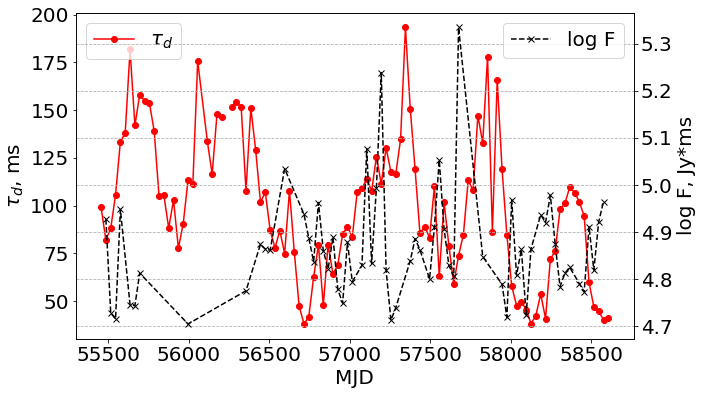

In [126]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(
    resul_tab_w50.MJD_mean, resul_tab_w50['W50_mean'], 'o-', color='red', label=r'$\tau_d$')
ax2.plot(
    resul_tab_cut_E.MJD_mean, np.log10(resul_tab_cut_E.E_mean), 'xb--', color='black', label='log F')

ax1.set_xlabel('MJD')
ax1.set_ylabel(r'$\tau_d$, ms')
ax2.set_ylabel(r'log F, Jy*ms')
#plt.axvline(55875.5, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(57839.92, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
#plt.axvline(58064.55, color='black', lw=3) # strongest glitch
#plt.axvline(58237.357, color='black', ls=(0, (3, 5, 1, 5)), lw=3)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.grid(True, ls='--')
#plt.xlim(58425, 58750)
plt.savefig('some_images/t_scatter+fluence_mean_bin_30.eps', format='eps')

In [106]:
resul_tab.to_csv('time_scatterig_bin30_kaz.csv', sep=',', header=True, index=True)

In [107]:
resul_gp.to_csv('gp_rate_bin30_kaz.csv', sep=',', header=True, index=True)